## Water Quality Prediction

Columns description : 
1. ph: pH of 1. water (0 to 14).
2. Hardness: Capacity of water to precipitate soap in mg/L.
3. Solids: Total dissolved solids in ppm.
4. Chloramines: Amount of Chloramines in ppm.
5. Sulfate: Amount of Sulfates dissolved in mg/L.
6. Conductivity: Electrical conductivity of water in μS/cm.
7. Organic_carbon: Amount of organic carbon in ppm.
8. Trihalomethanes: Amount of Trihalomethanes in μg/L.
9. Turbidity: Measure of light emiting property of water in NTU.
10. Potability: Indicates if water is safe for human consumption. Potable -1 and Not ptable -0


In [1]:
# Importing libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create or get sparksession
spark = SparkSession.builder.appName("classification").getOrCreate()

In [3]:
# Load data set
df = spark.read.csv("water_potability.csv", inferSchema=True, header=True)

In [4]:
# Showing first 5 rows
df.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|             NULL| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862|              NULL| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089|              N

In [5]:
# Showing the columns in our dataset
df.columns

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity',
 'Potability']

## Length of the data

In [6]:
# Showing how many rows in the data
print("The total number of records in the water quality dataset are", str(df.count()))

The total number of records in the water quality dataset are 3276


## Describe Data

In [7]:
# Summary Statistics
summary_stats = df.describe().toPandas()
print("Summary Statistics:")
summary_stats

Summary Statistics:


,summary,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,count,2785,3276,3276,3276,2495,3276,3276,3114,3276,3276
1,mean,7.080794504276819,196.36949601730177,22014.09252607711,7.122276793425787,333.7757766108134,426.2051106825521,14.284970247677341,66.39629294676803,3.9667861697910576,0.3901098901098901
2,stddev,1.594319518708812,32.879761476294185,8768.570827785921,1.583084889039709,41.4168404616727,80.82406405111186,3.3081619991268707,16.175008422218657,0.7803824084854121,0.48784916967025477
3,min,0.0,47.432,320.942611274359,0.3520000000000003,129.00000000000003,181.483753985146,2.1999999999999886,0.7379999999999995,1.45,0
4,max,13.999999999999998,323.124,61227.19600771213,13.127000000000002,481.03064230599716,753.3426195583046,28.30000000000001,124.0,6.739,1


## Check data types of each column

In [8]:
df.dtypes

[('ph', 'double'),
 ('Hardness', 'double'),
 ('Solids', 'double'),
 ('Chloramines', 'double'),
 ('Sulfate', 'double'),
 ('Conductivity', 'double'),
 ('Organic_carbon', 'double'),
 ('Trihalomethanes', 'double'),
 ('Turbidity', 'double'),
 ('Potability', 'int')]

In [9]:
# Printing the schema
df.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)



## Exploratory Data Analysis

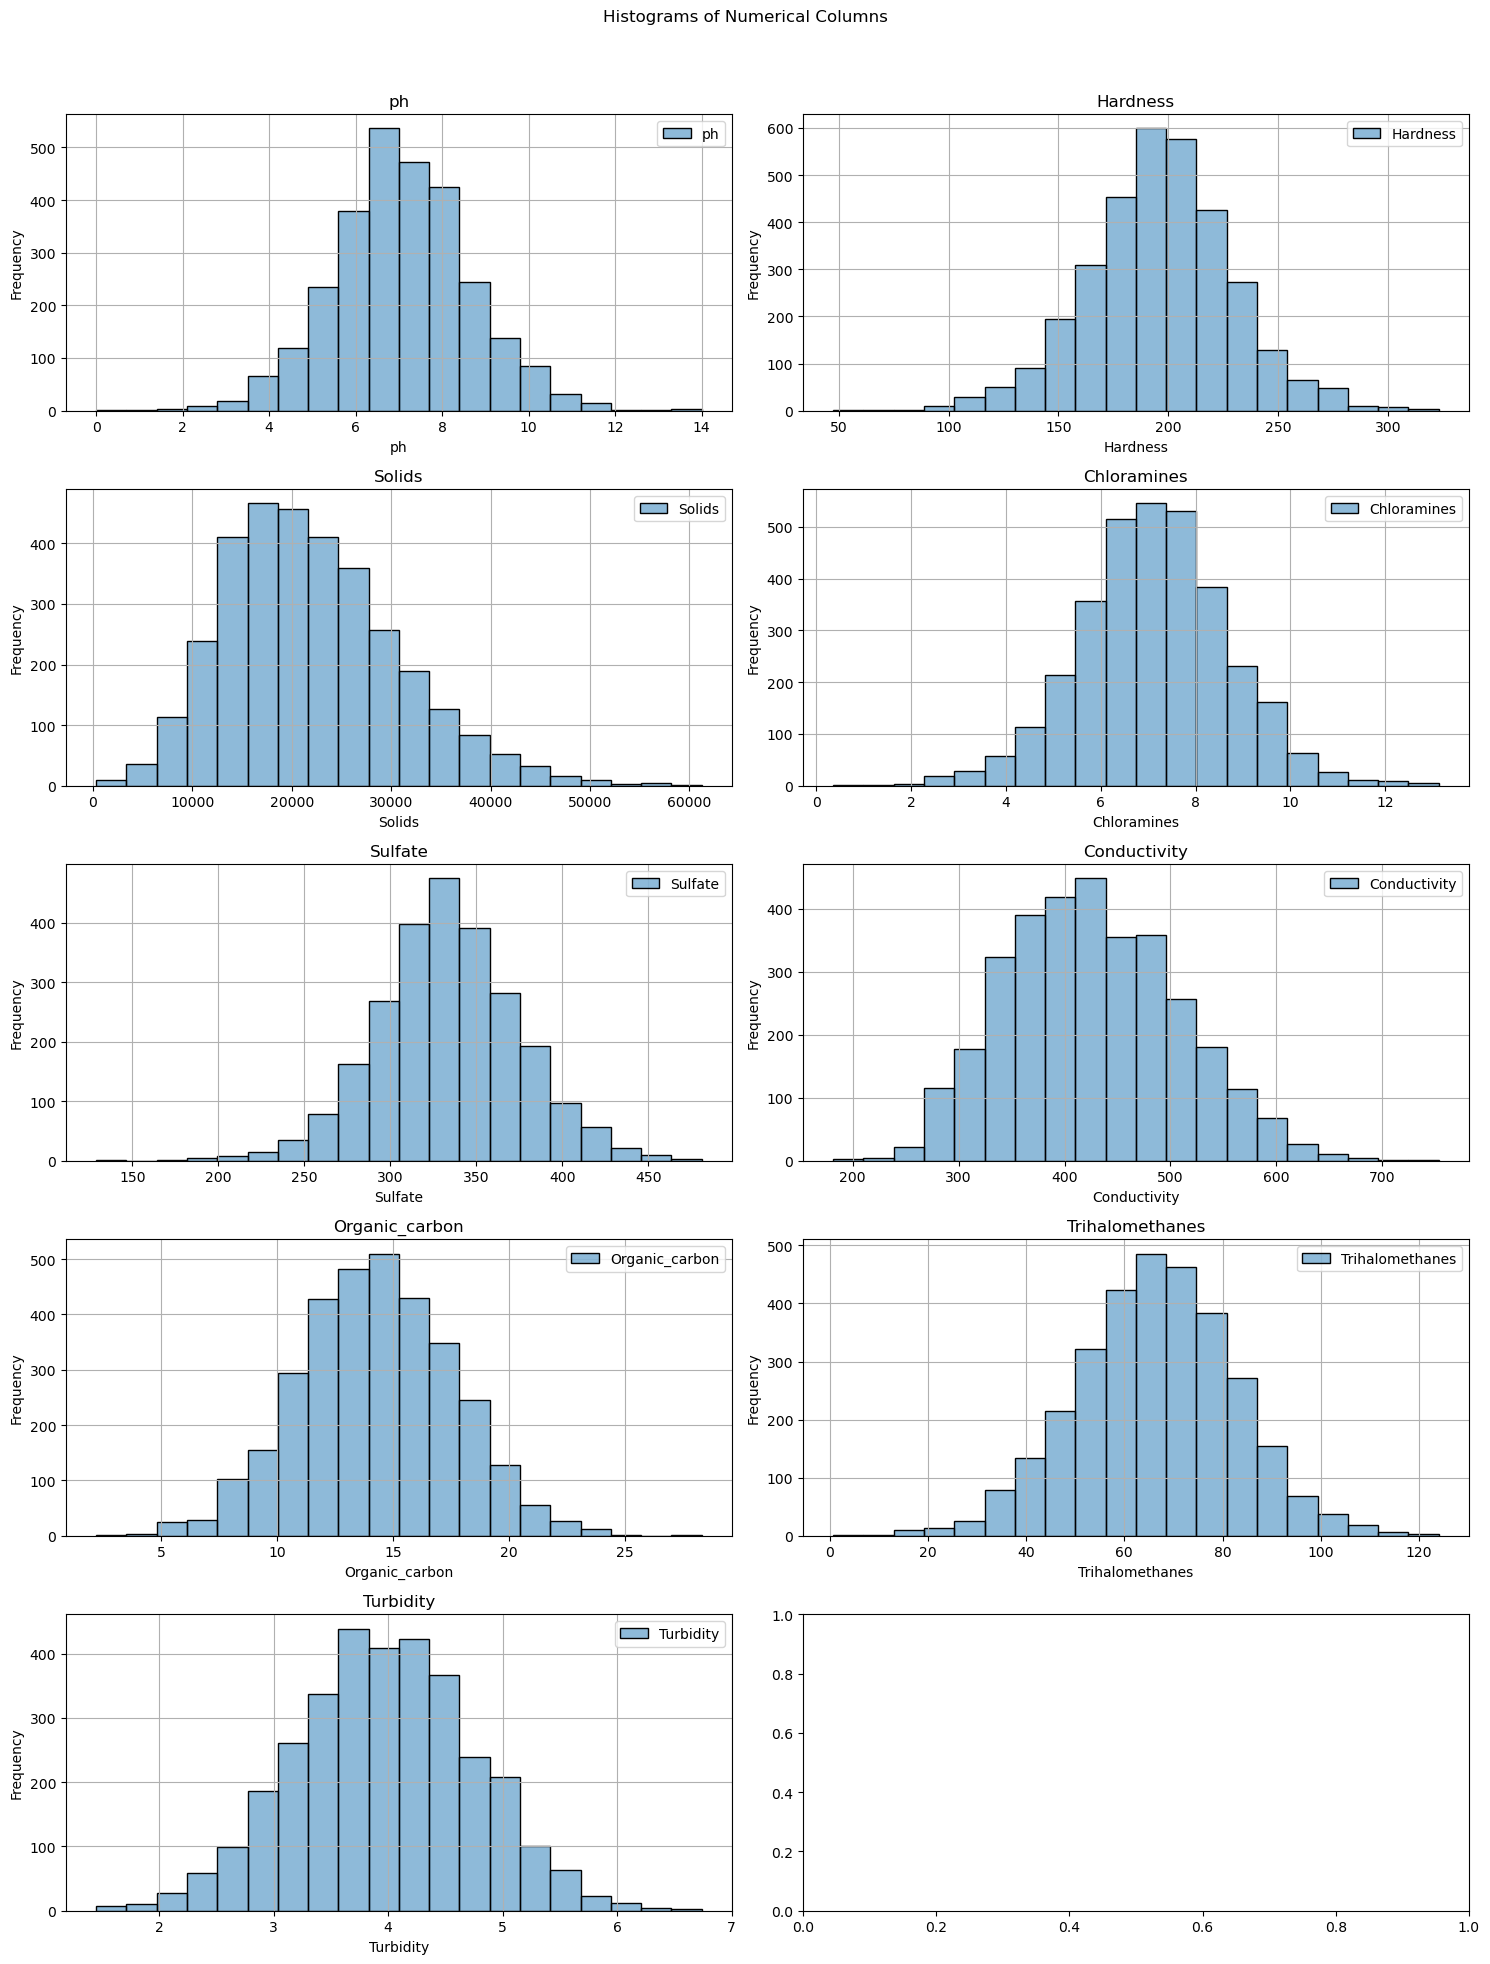

In [10]:
# Assign the numerical columns into a new variable
numerical_columns = ["ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"]

# Adjusting the figure size
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.suptitle('Histograms of Numerical Columns')
axes = axes.flatten()

# Plot histograms for each numerical column
for i, column in enumerate(numerical_columns):
    sns.histplot(df.select(column).toPandas(), bins=20, kde=False, color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Adjust layout for better spacing
plt.tight_layout(rect = [0, 0, 1, 0.96])

# Show the plot
plt.show()

## Check correlation

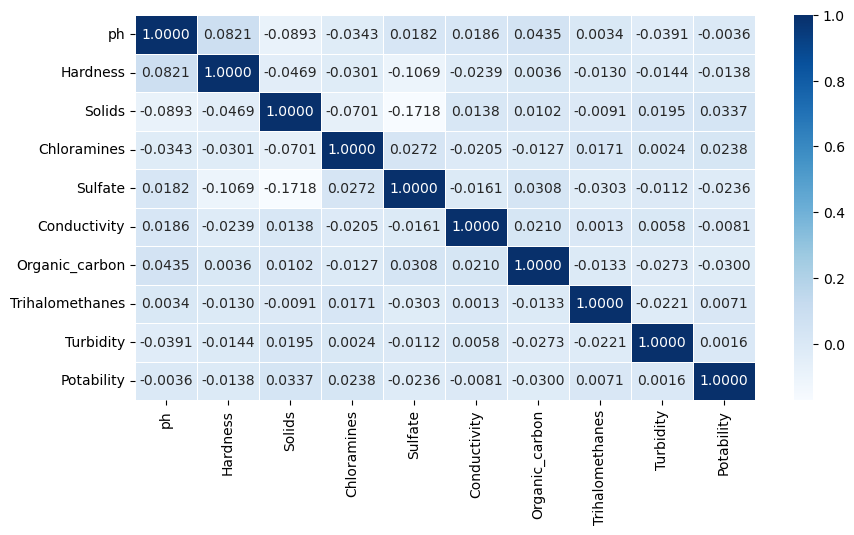

In [11]:
corr_matrix = df.toPandas().corr()
# Plot the correlation
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.4f', linewidths=0.5, linecolor='white',cmap='Blues')
plt.show()

### Target Features

+----------+-----+
|Potability|count|
+----------+-----+
|         1| 1278|
|         0| 1998|
+----------+-----+



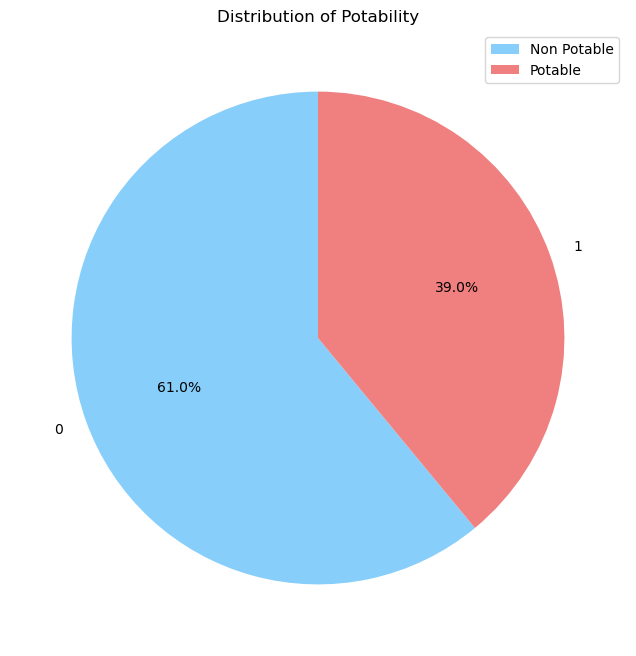

In [12]:
df.groupBy('Potability').count().show()

# Extract 'Potability' column as a Pandas DataFrame
target_df = df.select('Potability').toPandas()

# Count the occurrences of each target value
target_counts = target_df['Potability'].value_counts()

# Plotting Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=['lightskyblue', 'lightcoral'], startangle=90)
plt.title('Distribution of Potability')
plt.legend(['Non Potable', 'Potable'], loc='upper right')
plt.show()

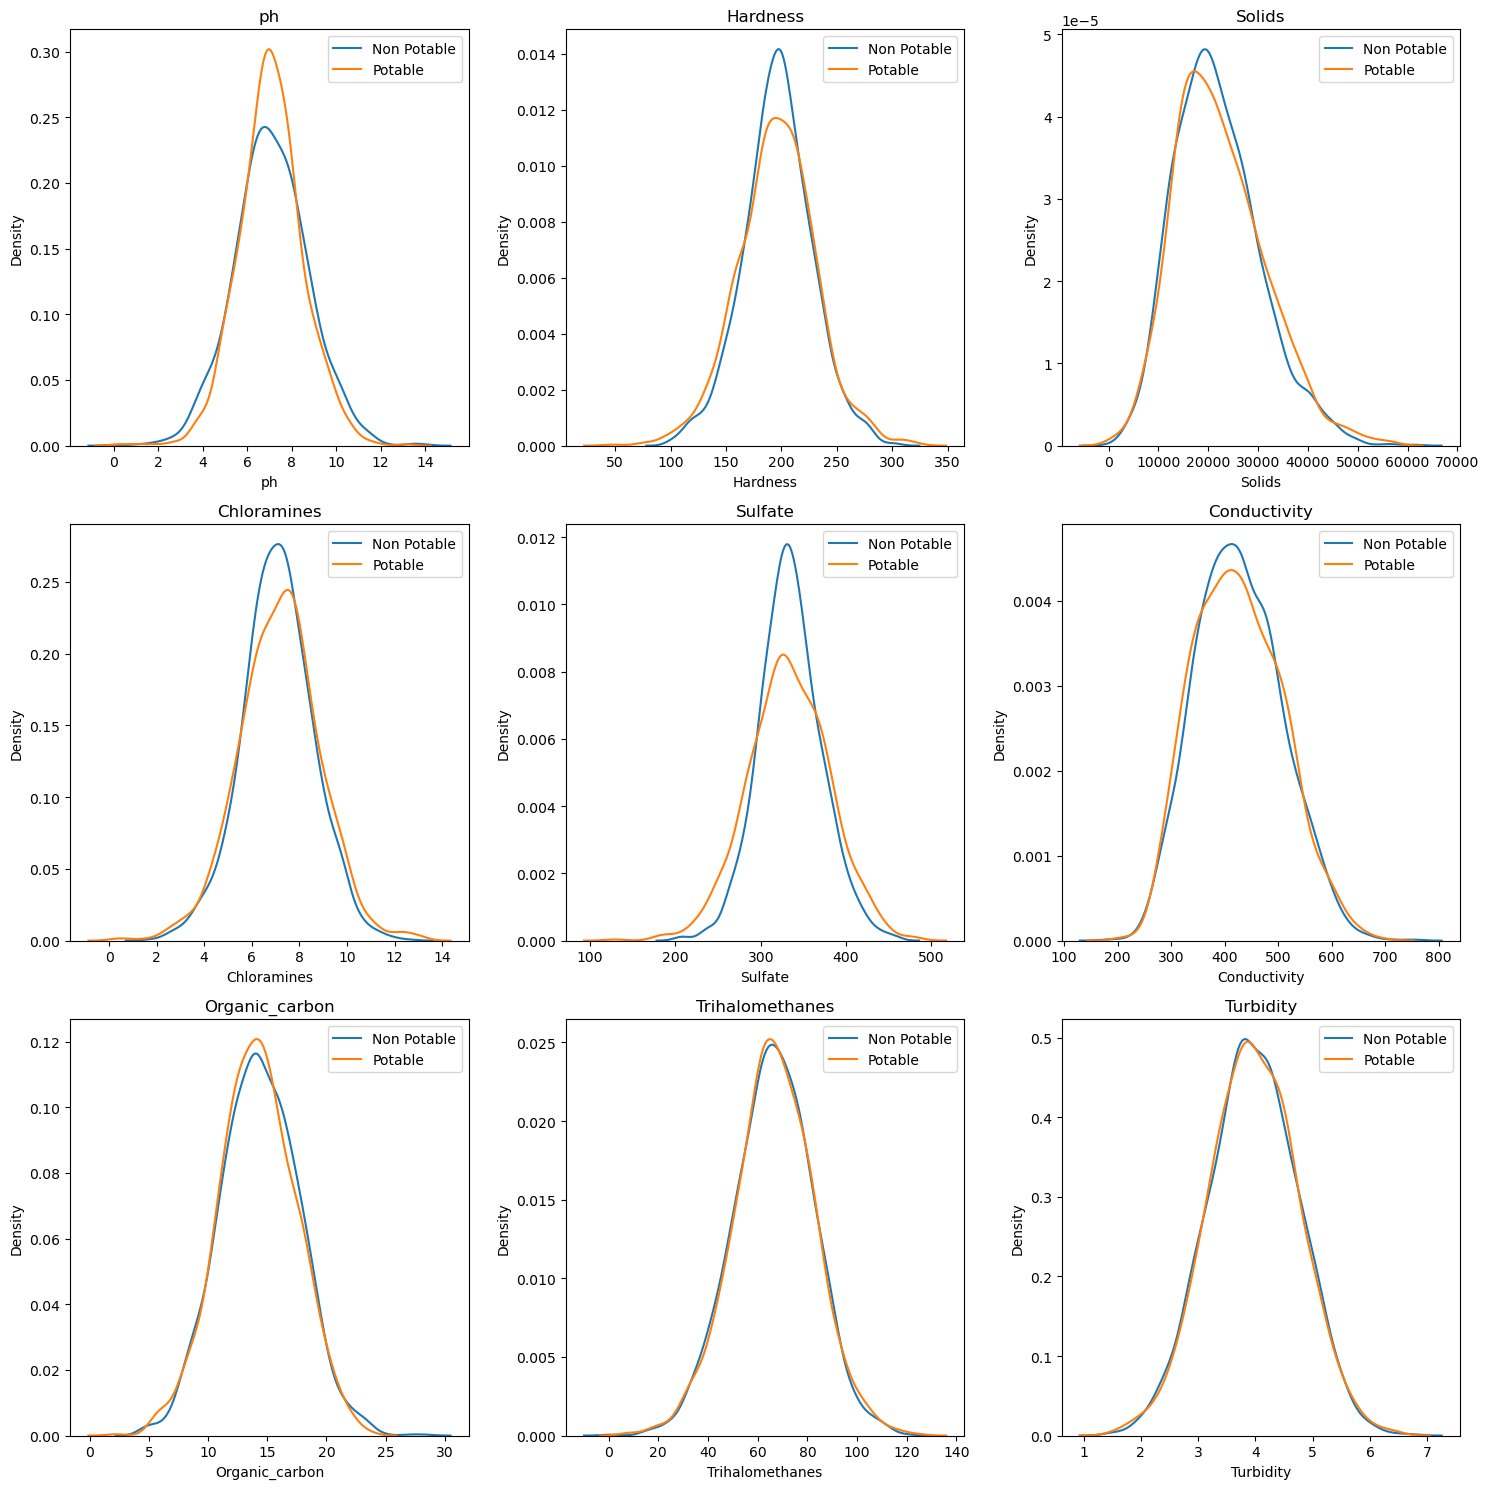

In [13]:
# Separate data for non-potable and potable
non_potable = df.filter(col("Potability") == 0)
potable = df.filter(col("Potability") == 1)

# Select numerical columns
numerical_columns = df.columns[:9]

# Create KDE plots using Matplotlib and Seaborn
plt.figure(figsize=(15, 15))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)
    plt.title(col)
    sns.kdeplot(x=non_potable.select(col).toPandas()[col], label="Non Potable")
    sns.kdeplot(x=potable.select(col).toPandas()[col], label="Potable")
    plt.legend()

plt.tight_layout()
plt.show()

## Cardinality Check

In [14]:
from pyspark.sql.functions import approxCountDistinct, countDistinct

def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[approx_count_distinct(c).alias(c) for c in df.columns])
    
    ## convert to pandas for efficient calculations
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True) 
    final_cardinality_df.rename(columns={0:'Cardinality'}, inplace=True) 
    
    #select variables with cardinality of 1
    vars_selected = final_cardinality_df['index'][final_cardinality_df['Cardinality'] <= cut_off] 
    
    return final_cardinality_df, vars_selected

cardinality_df, cardinality_vars_selected = cardinality_calculation(df)
cardinality_df

,index,Cardinality
0,ph,2718
1,Hardness,3229
2,Solids,3172
3,Chloramines,3428
4,Sulfate,2448
5,Conductivity,3118
6,Organic_carbon,3261
7,Trihalomethanes,2929
8,Turbidity,3309
9,Potability,2


## Missing value check

In [15]:
# Missing values check
from pyspark.sql.functions import count, when, isnan, col

# miss_percentage is set to 80%
def missing_calculation(df, miss_percentage=0.80):
    
    #checks for both NaN and null values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()
    ## convert to pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True) 
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True) 
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df
    
    #select variables with cardinality of 1
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage] 
    
    return final_missing_df, vars_selected
    
missing_df, missing_vars_selected = missing_calculation(df)
missing_df

,index,missing_count,missing_percentage
0,ph,491,0.149878
1,Hardness,0,0.000000
2,Solids,0,0.000000
3,Chloramines,0,0.000000
4,Sulfate,781,0.238400
5,Conductivity,0,0.000000
6,Organic_carbon,0,0.000000
7,Trihalomethanes,162,0.049451
8,Turbidity,0,0.000000
9,Potability,0,0.000000


From result above, we can see that ph, Sulfate, and Trihalomethanes have missing values. Because the percentage of missing values are not big, so we should probably attempt to fill these gaps.

Since we handling numerical data, we will first identify whether there are outliers

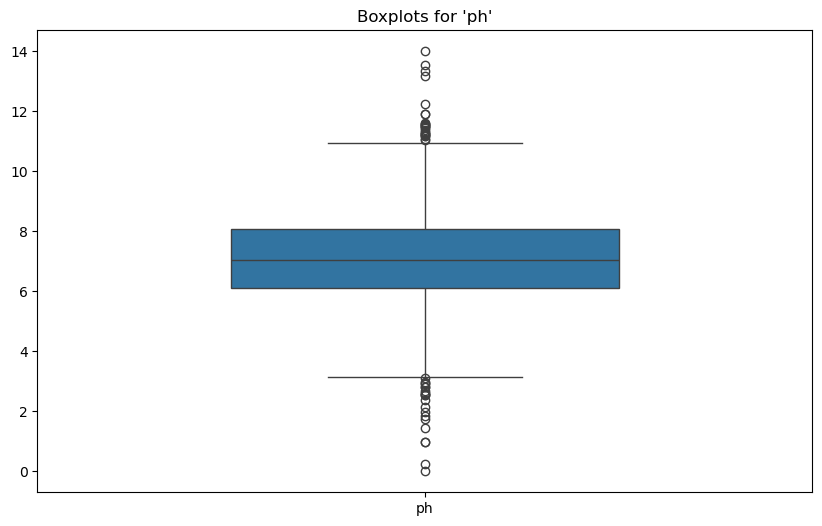

In [16]:
# Checking outliers for ph
boxplot = df.select('ph').toPandas()

# Create box plots using Pandas and Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=boxplot, width=0.5)
plt.title("Boxplots for 'ph'")
plt.show()

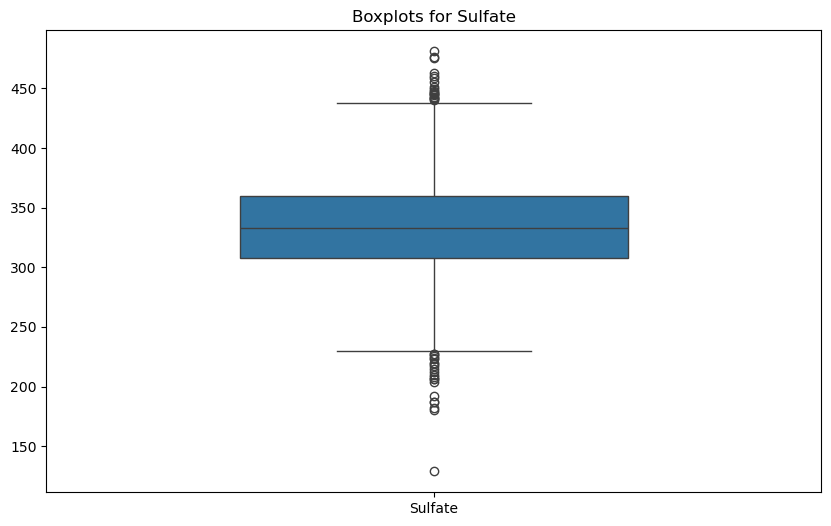

In [17]:
# Checking outliers for Sulfate
boxplot = df.select('Sulfate').toPandas()

# Create box plots using Pandas and Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=boxplot, width=0.5)
plt.title("Boxplots for Sulfate" )
plt.show()

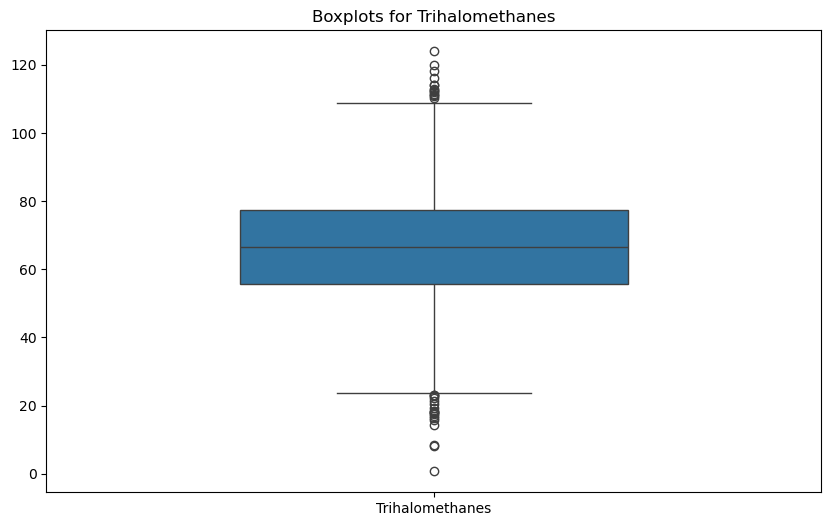

In [18]:
# Checking outliers for Trihalomethanes
boxplot = df.select('Trihalomethanes').toPandas()

# Create box plots using Pandas and Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=boxplot, width=0.5)
plt.title("Boxplots for Trihalomethanes" )
plt.show()

There are outliers found in 'ph', 'Sulfate' and 'Trihalomethanes', so we are going to impute with median

In [19]:
# Imputing missing values
impute_columns = ["ph", "Sulfate", "Trihalomethanes"]
medians = df.select(*(median(col(c)).alias(c) for c in impute_columns))

# Fill missing values with column medians
for column in impute_columns:
    median_value = medians.first()[column]
    df = df.na.fill(median_value, subset=[column])

# Recheck for missing values
df.select([count(when((col(c)=='') | col(c).isNull() |isnan(c), c)).alias(c) for c in df.columns]).show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|  0|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



## Feature Transformation

In [20]:
# Vector Assembler
feature_columns = df.columns[:-1]  # Exclude the target variable
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df = assembler.transform(df)

# Display the transformed DataFrame with the new 'features' column
df.select('features', 'Potability').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|features                                                                                                                                                                 |Potability|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[7.036752103833548,204.8904554713363,20791.318980747026,7.300211873184757,368.51644134980336,564.3086541722439,10.3797830780847,86.9909704615088,2.9631353806316407]     |0         |
|[3.71608007538699,129.42292051494425,18630.057857970347,6.635245883862,333.073545745888,592.8853591348523,15.180013116357259,56.32907628451764,4.500656274942408]        |0         |
|[8.099124189298397,224.23625939355776,19909.541732292393,9.275883602694089,333.07354

In [21]:
# Show the transformed DataFrame
df.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|            features|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|[7.03675210383354...|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862|  333.073545745888| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|[3.7160

# PCA 

In [22]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)
result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[20791.12144552291,-556.8388496486466,256.961017465426]    |
|[18629.900139570076,-586.770451958941,256.11041597817274]  |
|[19909.34459608303,-411.27851849967516,216.296035249744]   |
|[22018.199317005907,-355.63005180245676,242.65855943602872]|
|[17978.809333094352,-391.9608299709745,213.1528677292593]  |
|[28748.481565313683,-272.4050780090381,229.93402210001906] |
|[28749.458406657497,-274.5001739056337,265.0290599674196]  |
|[13671.925242829799,-468.53135551644027,195.23219200364892]|
|[14285.442690078089,-384.3896527873654,199.843774263061]   |
|[25484.284227897526,-555.3118841140005,282.1270694170244]  |
|[32452.42958747147,-417.0833242861445,241.26323626002474]  |
|[18767.453665416004,-356.9909796655627,217.9186421371334]  |
|[18730.650796463062,-341.6402285547174,198.1344864762628]  |
|[27331.

In [23]:
model.pc.toArray()

array([[-1.37479014e-05, -3.32372935e-04, -1.03550661e-03],
       [-1.75861474e-04,  1.11954048e-02, -4.23315855e-01],
       [ 9.99999786e-01,  1.33453815e-04,  4.84433012e-04],
       [-1.26645050e-05,  3.80162542e-04,  1.06373339e-03],
       [-6.17265093e-04,  6.47943987e-03,  9.05920075e-01],
       [ 1.27497159e-04, -9.99915795e-01,  1.13267425e-03],
       [ 3.86415985e-06, -8.49580600e-04,  2.21406886e-03],
       [-1.58239167e-05, -2.92712385e-04, -1.01922156e-02],
       [ 1.73956399e-06, -5.41391079e-05, -1.86510597e-05]])

In [24]:
model.explainedVariance

DenseVector([0.9999, 0.0001, 0.0])

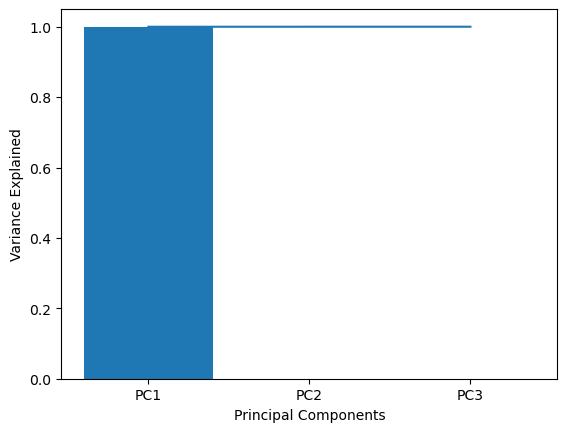

In [25]:
import matplotlib.pyplot as plt
import numpy as np
x = []
for i in range(0, len(model.explainedVariance)):
    x.append('PC' + str(i + 1))
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.bar(x, y)
plt.plot(x, z)

## Splitting data to training and testing

In [26]:
# Model Validation using RandomSplit
trainSet, testSet = df.randomSplit([0.8,0.2], seed = 123)

In [27]:
trainSet.show(5)

+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+
|                 ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|            features|
+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+
|                0.0|214.84614399470735|  49456.5871084231| 7.897539036774782|  333.073545745888| 583.4488493097667| 7.702328207475318| 77.71289111623837| 4.928839979650702|         0|[0.0,214.84614399...|
|0.22749905020219874| 152.5301111764229|39028.599340290755|3.4624920476792767|283.69378223429663| 443.0292321286284|13.201943203829217| 62.32271110691731| 3.545741437567914|   

In [28]:
testSet.show(5)

+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+----------+--------------------+
|                ph|          Hardness|            Solids|       Chloramines|          Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|        Turbidity|Potability|            features|
+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+----------+--------------------+
| 0.975577989772022|221.20411425336272|31145.110738714637|7.6155833766556285|333.6778429254695| 439.1127646925047|21.145954462369048| 66.62248509808484|2.533996269917253|         0|[0.97557798977202...|
| 1.844538366498842| 233.7643427207269|28689.595777682935| 7.724432299963912| 333.073545745888|410.38726383770813|15.611859296305227| 54.29944409418921|5.013463351103733|         0|[1.8445

## Modeling

1. Logistic Regression Model

In [29]:
# Create a Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='Potability')

In [30]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01, 0.001])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [10, 15, 20, 30])
             .build())

In [31]:
# Define an evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Potability")

In [32]:
# Create CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

In [33]:
# Fit the model
model = cv.fit(trainSet)

In [34]:
# Make predictions on the test data
predictions = model.transform(testSet)

In [35]:
# Show predictions
predictions.select("Potability", "prediction", "probability").show()

+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.59823366610495...|
|         0|       0.0|[0.58724426570690...|
|         0|       0.0|[0.52613487329168...|
|         0|       0.0|[0.57073735103045...|
|         0|       0.0|[0.55526057854450...|
|         0|       0.0|[0.57517037569953...|
|         0|       0.0|[0.58355060529948...|
|         1|       0.0|[0.60282027205380...|
|         0|       0.0|[0.57932203098336...|
|         0|       0.0|[0.55832583691967...|
|         1|       0.0|[0.57254344856114...|
|         1|       0.0|[0.60868778351330...|
|         1|       0.0|[0.62726714810836...|
|         0|       0.0|[0.60691773526231...|
|         0|       0.0|[0.59614531935104...|
|         0|       0.0|[0.59878379899177...|
|         1|       0.0|[0.60880542512071...|
|         0|       0.0|[0.54805534954902...|
|         0|       0.0|[0.57391741025932...|
|         

2. Random Forest

In [36]:
# Create a Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='Potability')

In [37]:
pipeline_rf = Pipeline(stages=[rf])

In [38]:
# Create ParamGrid for Cross Validation
paramGrid_rf = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .build())

In [39]:
from pyspark.ml.tuning import CrossValidator
evaluator_rf = BinaryClassificationEvaluator(labelCol="Potability")
# CrossValidator
cv_rf = CrossValidator(estimator=pipeline_rf,
                    estimatorParamMaps=paramGrid_rf,
                    evaluator=evaluator_rf,
                    numFolds=5)

In [40]:
# Fit the model
model_rf = cv_rf.fit(trainSet)

In [41]:
# Make predictions on the test data
predictions_rf = model_rf.transform(testSet)

In [42]:
# Show predictions
predictions_rf.select("Potability", "prediction", "probability").show()

+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.62899865661353...|
|         0|       0.0|[0.70715243872548...|
|         0|       0.0|[0.69444444444444...|
|         0|       0.0|[0.68215768116526...|
|         0|       0.0|[0.72717338408614...|
|         0|       0.0|[0.79287736395339...|
|         0|       1.0|[0.49869433107795...|
|         1|       0.0|[0.71342151624603...|
|         0|       1.0|[0.44446236441929...|
|         0|       0.0|[0.68942159023688...|
|         1|       1.0|[0.46198647656782...|
|         1|       0.0|[0.53075391235795...|
|         1|       0.0|[0.57095071510338...|
|         0|       0.0|[0.78388215627225...|
|         0|       0.0|[0.67926828690444...|
|         0|       0.0|[0.78789908081275...|
|         1|       0.0|[0.68563135908077...|
|         0|       0.0|[0.53811978247182...|
|         0|       0.0|[0.75038002803668...|
|         

3. Decision Tree

In [43]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create a Decision Tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Potability")

In [44]:
paramGrid_dt = (ParamGridBuilder()
              .addGrid(dt.maxDepth, [3, 5, 7])
              .addGrid(dt.maxBins, [32, 64, 128])
              .build())

# paramGrid_dt = (ParamGridBuilder()
#               .addGrid(dt.maxDepth, [3, 5, 7])
#               .addGrid(dt.maxBins, [32, 64, 128])
#               .addGrid(dt.minInfoGain, [0.0, 0.1, 0.2])
#               .addGrid(dt.minInstancesPerNode, [1, 5, 10])
#               .addGrid(dt.impurity, ['gini', 'entropy'])
#               .build())

In [45]:
evaluator_dt = BinaryClassificationEvaluator(labelCol="Potability")

# Create CrossValidator
cv_dt = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid_dt,
                    evaluator=evaluator_dt,
                    numFolds=5)

In [46]:
# Fit the model
model_dt = cv_dt.fit(trainSet)

In [47]:
# Make predictions on the test data
predictions_dt = model_dt.transform(testSet)

In [48]:
# Show predictions
predictions_dt.select("Potability", "prediction", "probability").show()

+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.91666666666666...|
|         0|       0.0|[0.91666666666666...|
|         0|       1.0|           [0.0,1.0]|
|         0|       0.0|[0.91666666666666...|
|         0|       0.0|           [1.0,0.0]|
|         0|       0.0|[0.91666666666666...|
|         0|       0.0|[0.91666666666666...|
|         1|       0.0|[0.91666666666666...|
|         0|       0.0|[0.94117647058823...|
|         0|       0.0|           [1.0,0.0]|
|         1|       1.0|           [0.0,1.0]|
|         1|       0.0|[0.66666666666666...|
|         1|       1.0|           [0.4,0.6]|
|         0|       1.0|           [0.4,0.6]|
|         0|       0.0|[0.91666666666666...|
|         0|       0.0|[0.91666666666666...|
|         1|       0.0|[0.91666666666666...|
|         0|       1.0|           [0.0,1.0]|
|         0|       0.0|[0.91666666666666...|
|         

## Model Evaluation

1. Logistic Regression

In [49]:
# Define evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedAccuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="f1")

In [50]:
# Evaluate the model on test data
accuracy_lr = evaluator.evaluate(predictions)
precision_lr = precision_evaluator.evaluate(predictions)
recall_lr = recall_evaluator.evaluate(predictions)
f1score_lr = f1_evaluator.evaluate(predictions)

print(f"Accuracy = {accuracy_lr}")
print(f"Precision = {precision_lr}")
print(f"Recall = {recall_lr}")
print(f"F1-Score = {f1score_lr}")

Accuracy = 0.49790727008638513
Precision = 0.38268899530160794
Recall = 0.6186186186186187
F1-Score = 0.47285875857304427


In [51]:
# Get the best model from Cross Validation
best_model = model.bestModel

In [52]:
# Get the ROC curve
roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Area under ROC = {roc}")

Area under ROC = 0.49790727008638513


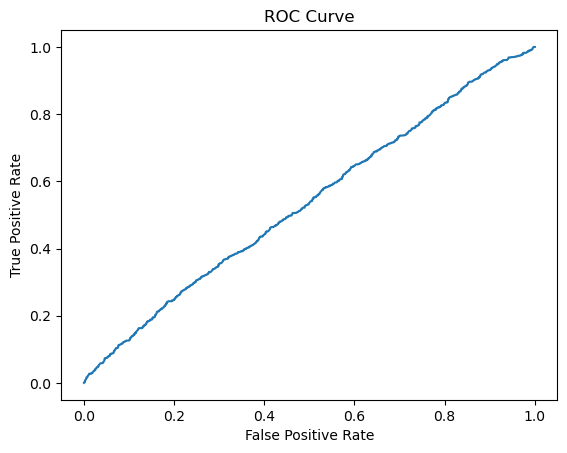

In [53]:
# If the best model supports getting summary, plot ROC curve
if hasattr(best_model, "summary"):
    trainingSummary = best_model.summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc['FPR'], roc['TPR'])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
else:
    print("The best model doesn't support ROC curve.")

2. Random Forest

In [54]:
# Define evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedAccuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="f1")

In [55]:
# Evaluate the model on test data
accuracy_rf = evaluator.evaluate(predictions_rf)
precision_rf = precision_evaluator.evaluate(predictions_rf)
recall_rf = recall_evaluator.evaluate(predictions_rf)
f1score_rf = f1_evaluator.evaluate(predictions_rf)

print(f"Accuracy = {accuracy_rf}")
print(f"Precision = {precision_rf}")
print(f"Recall = {recall_rf}")
print(f"F1-Score = {f1score_rf}")

Accuracy = 0.6778247075911624
Precision = 0.6670141152049968
Recall = 0.6711711711711712
F1-Score = 0.6320270263910759


3. Decision Tree

In [56]:
# Define evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedAccuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="f1")

In [57]:
# Evaluate the model on test data
accuracy_dt = evaluator.evaluate(predictions_dt)
precision_dt = precision_evaluator.evaluate(predictions_dt)
recall_dt = recall_evaluator.evaluate(predictions_dt)
f1score_dt = f1_evaluator.evaluate(predictions_dt)

print(f"Accuracy = {accuracy_dt}")
print(f"Precision = {precision_dt}")
print(f"Recall = {recall_dt}")
print(f"F1-Score = {f1score_dt}")

Accuracy = 0.4711652396605764
Precision = 0.6383158086861791
Recall = 0.6471471471471472
F1-Score = 0.5866509932738468
